In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19a

## Simple RNN - One feature


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

%matplotlib inline

2024-05-25 08:18:16.848441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 08:18:16.848518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 08:18:16.865497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 08:18:16.906589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 08:18:17.820029: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 20  # number of cycles to run
ALPHA = 0.1  # learning rate
TEST_SIZE = 0.2 # What fraction we want to keep for testing
BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }
CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Load Weather Data

In [4]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
data_df.shape

(96453, 12)

In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], 
                                     utc=True)

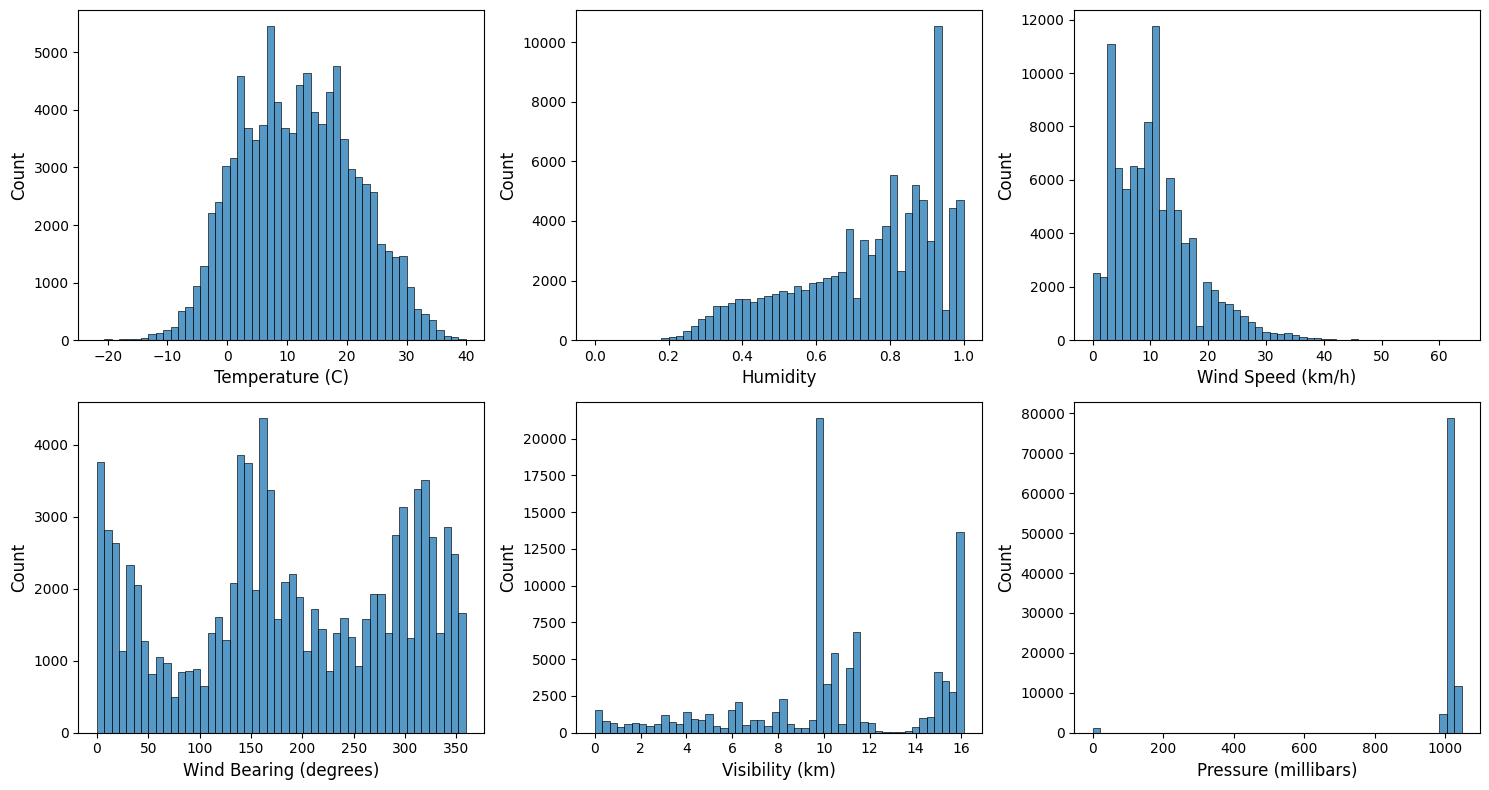

In [7]:
num_cols = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
             'Visibility (km)', 'Pressure (millibars)']

fig, axes = plt.subplots(2,3, figsize=(15,8))

axes = axes.ravel()

for count, col in enumerate(num_cols):
    
    ax =axes[count]
    
    sns.histplot(data_df, x = col, ax = ax, bins = 50)

plt.tight_layout()

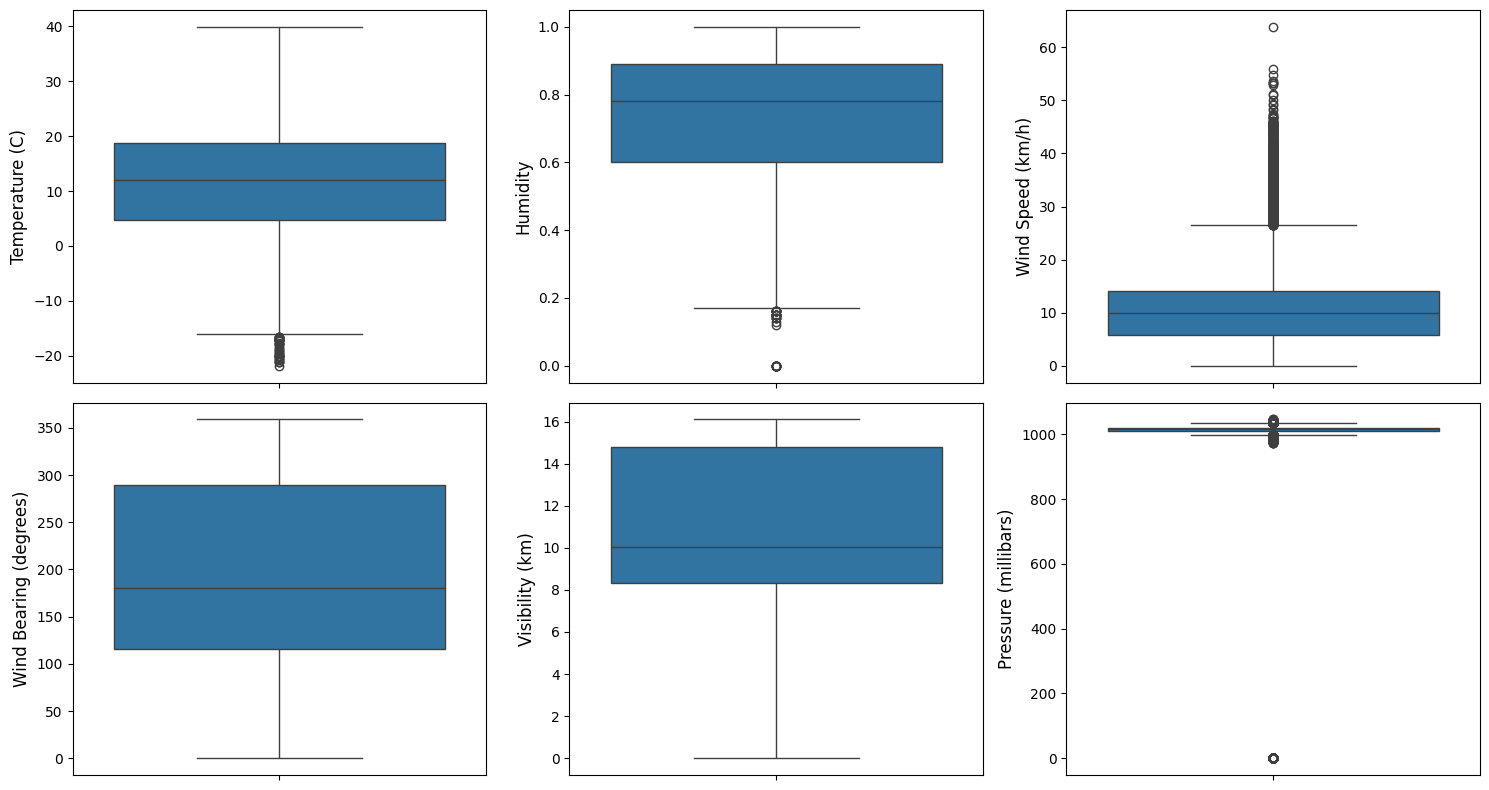

In [8]:
fig, axes = plt.subplots(2,3, figsize=(15,8))

axes = axes.ravel()

for count, col in enumerate(num_cols):

    sns.boxplot(y=col, data=data_df, ax = axes[count])

plt.tight_layout()
# Show the plot
plt.show()

In [9]:
data_df[num_cols].corr()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,-0.632255,0.008957,0.029988,0.392847,-0.005447
Humidity,-0.632255,1.000000,-0.224951,0.000735,-0.369173,0.005454
Wind Speed (km/h),0.008957,-0.224951,1.000000,0.103822,0.100749,-0.049263
Wind Bearing (degrees),0.029988,0.000735,0.103822,1.000000,0.047594,-0.011651
Visibility (km),0.392847,-0.369173,0.100749,0.047594,1.000000,0.059818
Pressure (millibars),-0.005447,0.005454,-0.049263,-0.011651,0.059818,1.000000


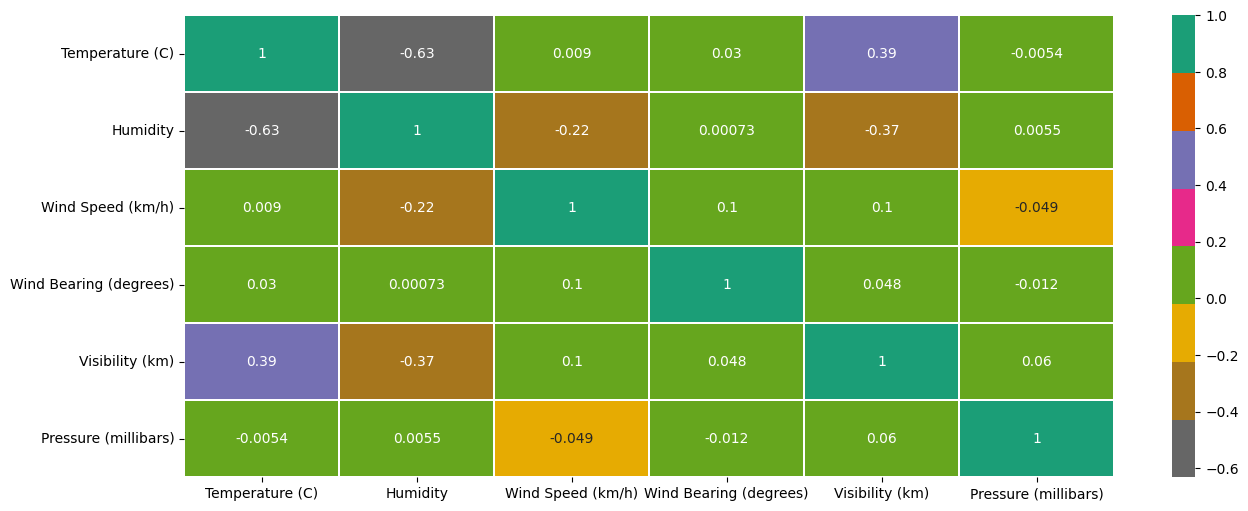

In [10]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap='Dark2_r', linewidths = .2)
plt.show()

In [11]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [12]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [13]:
# comment/uncomment following lines if you want part or full dataset

# startDate = pd.to_datetime('2007-1-1', utc=True)
# endDate = pd.to_datetime('2008-1-1', utc=True)
# temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

In [14]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [15]:
temp_df.shape

(96453, 2)

## Plotting samples

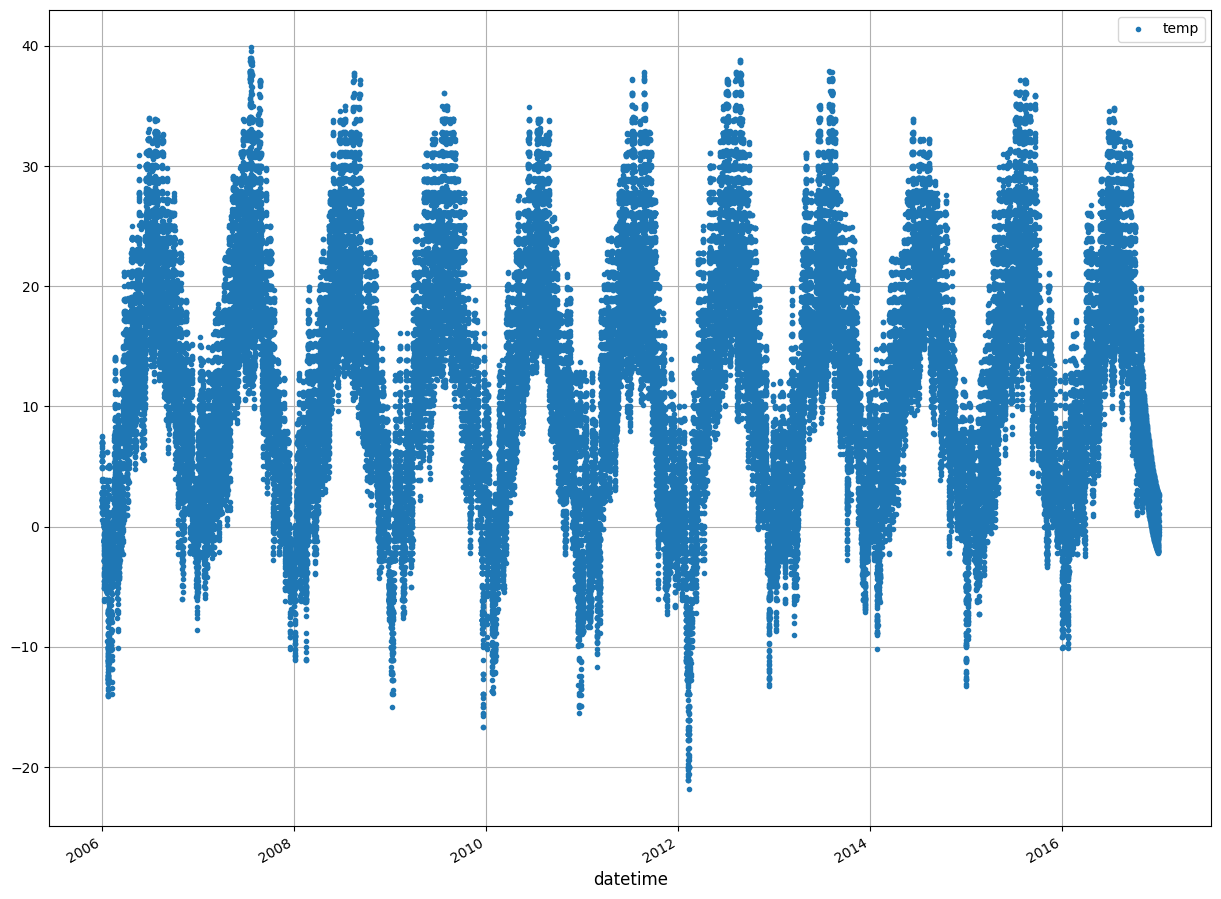

In [16]:
fig, ax = plt.subplots(figsize = (15,12))
temp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [17]:
h_units = 100
input_shape = (1, 10000)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'tanh' ))

model.add(tf.keras.layers.Dense(1, activation = 'linear' ))

2024-05-25 08:18:24.353622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 08:18:24.454696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 08:18:24.455025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

print ('Shape of Matrix:')
print ('Wax = ', wax,'; Waa = ', waa, '; baa = ', baa,'; Way = ', way,'; bay = ', bay)

Shape of Matrix:
Wax =  (10000, 100) ; Waa =  (100, 100) ; baa =  (100,) ; Way =  (100, 1) ; bay =  (1,)


In [19]:
temp_df

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222


In [20]:
time_step = 24

In [21]:
temp_df.shape[0]

96453

In [22]:
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [23]:
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [24]:
y_df.shape, len(y_df)*time_step

((4018, 2), 96432)

In [25]:
temp_df.shape

(96453, 2)

In [26]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]

In [27]:
X_df['temp'].values.shape

(96432,)

In [28]:
y_df.shape

(4018, 2)

In [29]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [30]:
X = X[:, :23]
X.shape

(4018, 23)

## Note

Need to reshape the inputs into the 3D format as expected by the SimpleRNNs, namely [samples, timesteps, features].

In [31]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [32]:
X.shape

(4018, 23, 1)

In [33]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [34]:
h_units = 256
input_shape=(time_step-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/20


2024-05-25 08:18:25.943910: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ae3914e1c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-25 08:18:25.943977: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-25 08:18:25.953310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 08:18:25.977896: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1716605306.049199    6275 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 [==============================] - 2s 8ms/step - loss: 8.9833 - root_mean_squared_error: 2.9972 - val_loss: 0.9442 - val_root_mean_squared_error: 0.9717
Epoch 2/20
101/101 [==============================] - 1s 7ms/step - loss: 1.5680 - root_mean_squared_error: 1.2522 - val_loss: 1.2825 - val_root_mean_squared_error: 1.1325
Epoch 3/20
101/101 [==============================] - 1s 7ms/step - loss: 1.3660 - root_mean_squared_error: 1.1687 - val_loss: 0.7746 - val_root_mean_squared_error: 0.8801
Epoch 4/20
101/101 [==============================] - 1s 7ms/step - loss: 1.1828 - root_mean_squared_error: 1.0876 - val_loss: 0.7766 - val_root_mean_squared_error: 0.8813
Epoch 5/20
101/101 [==============================] - 1s 6ms/step - loss: 1.0847 - root_mean_squared_error: 1.0415 - val_loss: 0.6900 - val_root_mean_squared_error: 0.8306
Epoch 6/20
101/101 [==============================] - 1s 7ms/step - loss: 1.0971 - root_mean_squared_error: 1.0474 - val_loss: 0.7707 - val_root_mean_s

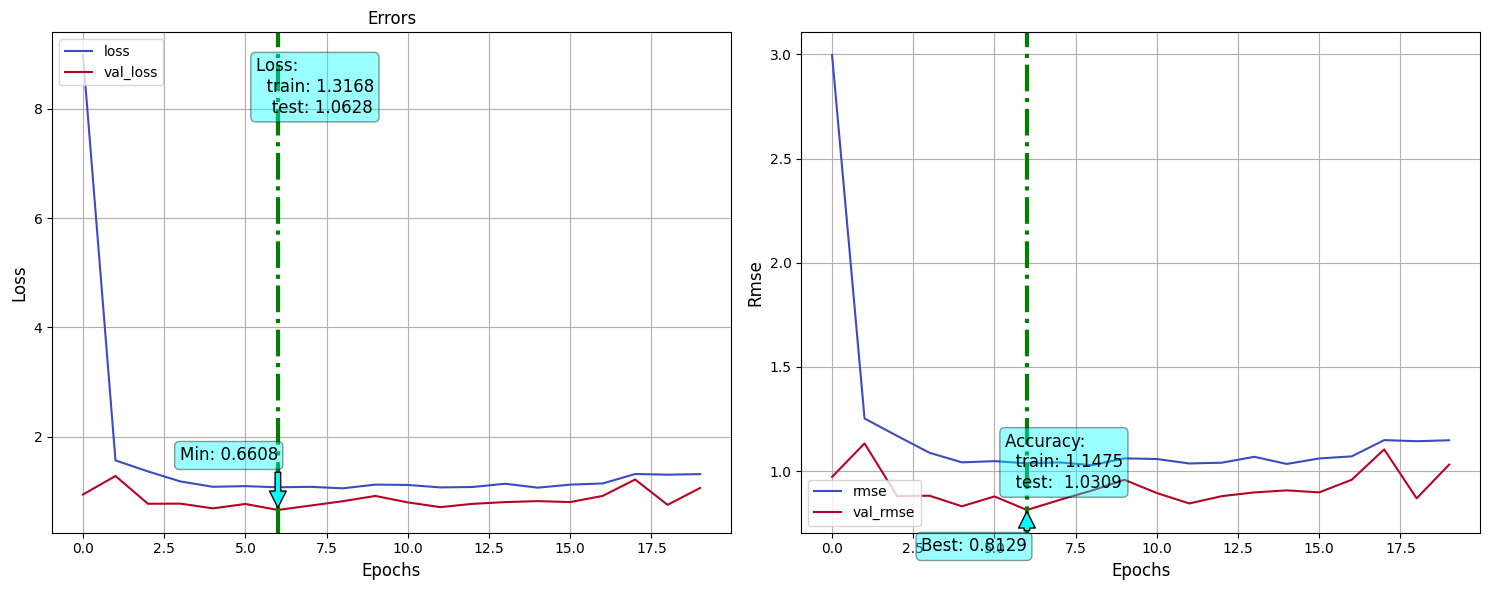

In [37]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


fn_plot_tf_hist(hist_df)

In [38]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 0s 2ms/step


In [39]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.420700
48,2006-01-02,1.694444,1.757719
72,2006-01-03,2.200000,1.063096
96,2006-01-04,1.666667,0.968115
120,2006-01-05,1.805556,1.728627


In [40]:
res_df.tail()

,datetime,temp,pred
96336,2016-12-27,-1.627778,-0.699199
96360,2016-12-28,-1.677778,-0.746060
96384,2016-12-29,-1.727778,-0.791965
96408,2016-12-30,-1.777778,-0.838027
96432,2016-12-31,-1.822222,-0.879736


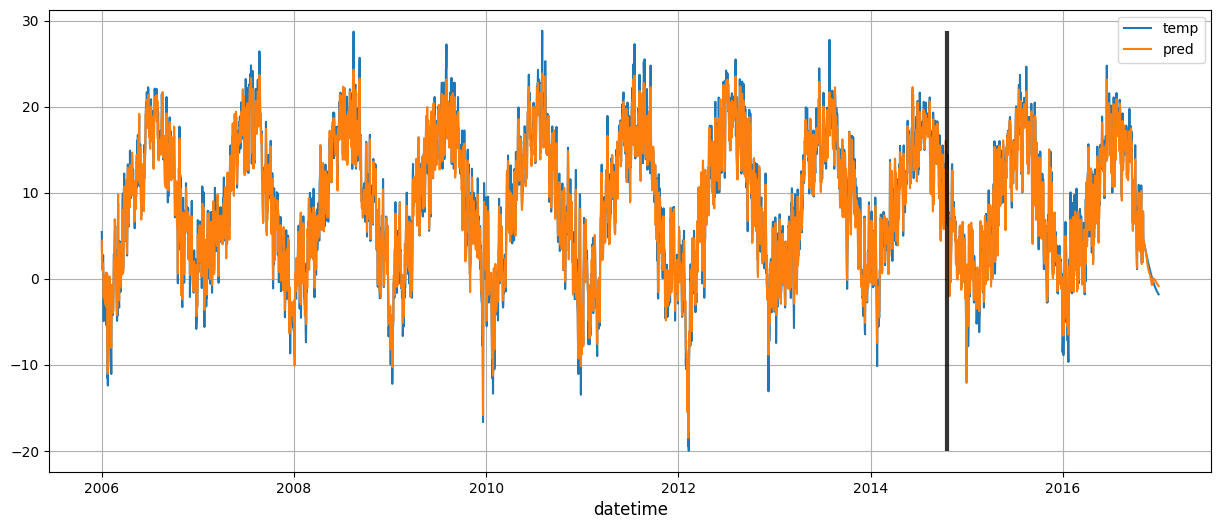

In [41]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()

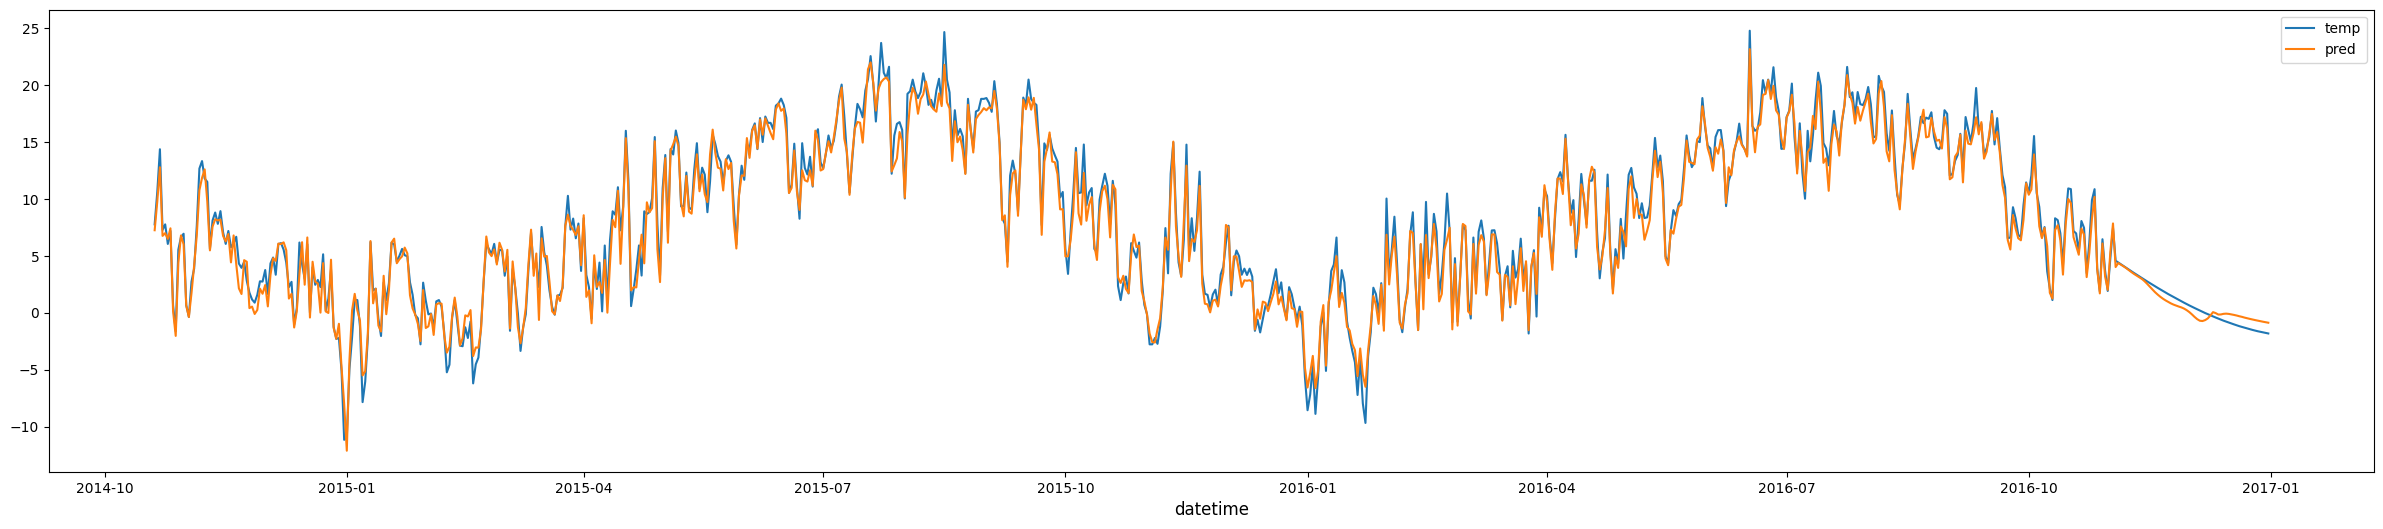

In [44]:
fig, ax = plt.subplots(figsize=(30,6))
res_df.iloc[X_train.shape[0]:].plot(x='datetime', y=['temp','pred'], ax = ax);